In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch_geometric 
from sklearn.model_selection import train_test_split
import numpy as np
from torch_geometric.utils import from_networkx
import networkx as nx
import plotly.graph_objs as go
from plotly.subplots import make_subplots

#librerias

import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import time
import re 
import random
import json 
import time
import plotly.express as px
from dataclasses import dataclass      

In [6]:
def keep_line(line):
    line_split=line.split()
    try:
        int(line_split[0])
        #si no dio error, okey entra
        return True
    except:
        return False
    

#vamos a hacer una función para cargar todos los datos de una   
@dataclass
class Data:
    folder: str
    load_stage: int
    base_dir:str = "/home/arturosf/Documentos/repos/DeepElasticity/data/001-LinearElasticity"
    E: str = None
    initialPosition_data_pd: pd.DataFrame =None
    stress_data_pd: pd.DataFrame =None
    displacement_data_pd: pd.DataFrame=None
    restricted_data_pd: pd.DataFrame =None
    force_data_pd: pd.DataFrame =None 
    final_data_pd: pd.DataFrame =None
    collocation_data_np:pd.DataFrame =None
    Pos_min: np.ndarray = None
    Pos_max: np.ndarray = None
    adjancet_matrix: np.ndarray=None

    @classmethod
    def keep_line(line):
        line_split=line.split()
        try:
            int(line_split[0])
            #si no dio error, okey entra
            return True
        except:
            return False

    def load_data(self,load_stage=10,normalize_pos=False):
        # carga las posiciones de los nodos    
        initialPosition_data_path = f"{self.base_dir}/ARTURO_TEST_1/NODES.txt"

        with open(initialPosition_data_path,"r") as f:
            aux_list=f.readlines()

        initialPosition_data=[i for i in aux_list if keep_line(i)]
        initialPosition_data=[i.strip("\n") for i in initialPosition_data]
        initialPosition_data=[i.split() for i in initialPosition_data]
        initialPosition_data_np=np.array(initialPosition_data).astype(float)[:,[0,1,2,3]]
        self.initialPosition_data_pd=pd.DataFrame(initialPosition_data_np,columns=["Node","X","Y","Z"]).set_index("Node")
        self.Pos_min=self.initialPosition_data_pd.min().to_numpy()
        self.Pos_max=self.initialPosition_data_pd.max().to_numpy()

        #noramlizamos las posiciones 
        if normalize_pos:
            self.initialPosition_data_pd=(self.initialPosition_data_pd-self.initialPosition_data_pd.min())/(self.initialPosition_data_pd.max()-self.initialPosition_data_pd.min())

        #carga el streess
        if self.E is not None:
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES_E{self.E}.txt"
        else: 
            stress_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_STRESSES.txt"
        with open(stress_data_path,"r") as f:
            aux_list=f.readlines()


        stress_data=[i for i in aux_list if keep_line(i)]
        stress_data=[i.strip("\n").strip() for i in stress_data]
        patron = "[-.\d]+E-*\d{3}|^\d{0,4}|0\.0000"

        stress_data=[re.findall(patron,i) for i in stress_data]
        stress_data=np.array(stress_data,dtype=float)
        self.stress_data_pd=pd.DataFrame(stress_data,columns=["Node","SX","SY","SZ","SXY","SYZ","SXZ"]).set_index("Node")[["SX","SY","SZ","SYZ","SXZ","SXY"]] # lo queremos asi : s11,s22,s33,s23,s13,s12

        # cargar datos de desplazamiento  
        if self.E is not None:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP_E{self.E}.txt"
        else:
            displacement_data_path = f"{self.base_dir}/{self.folder}/PSOL_{load_stage}_NODAL_DISP.txt"

        with open(displacement_data_path,"r") as f:
            aux_list=f.readlines()


        displacement_data=[i for i in aux_list if keep_line(i)]
        displacement_data=[i.strip("\n").strip() for i in displacement_data]
        patron = r"[-.\d]+E-*\d{3}|^\d{0,4}|-?\d+\.\d+|0\.0000"

        displacement_data=[re.findall(patron,i) for i in displacement_data]
        displacement_data=np.array(displacement_data,dtype=float)
        self.displacement_data_pd=pd.DataFrame(displacement_data,columns=["Node","UX","UY","UZ","USUM"]).set_index("Node")

        # cargar datos de boundaries en el movimiento
        #cargar los nodos fijos
        with open(f"{self.base_dir}/ARTURO_TEST_1/RESTRINGED_NODES.txt","r") as f:
            restricted_data=f.readlines()

        restricted_data=[i for i in restricted_data if keep_line(i)]
        restricted_data=[i.strip("\n") for i in restricted_data]
        restricted_data=[i.split() for i in restricted_data]
        restricted_data_np=np.array(restricted_data)[:,[0,1]]
        self.restricted_data_pd=pd.DataFrame(restricted_data_np,columns=["Node","Direccion"])
        self.restricted_data_pd=self.restricted_data_pd.groupby("Node")["Direccion"].apply(lambda x : list(x)).to_frame().sort_index()
        self.restricted_data_pd.index=self.restricted_data_pd.index.astype(int)
        self.restricted_data_pd=self.restricted_data_pd.sort_index()
        self.restricted_data_pd=self.restricted_data_pd.rename(columns={"Direccion":"Restricciones"})

        with open(f"{self.base_dir}/ARTURO_TEST_1/FORCE_ON_NODES.txt","r") as f:
            force_data=f.readlines()


        force_data=[i for i in force_data if keep_line(i)]
        force_data=[i.strip("\n") for i in force_data]
        force_data=[i.split() for i in force_data]
        force_data_np=np.array(force_data)[:,[0,1,2]]
        self.force_data_pd=pd.DataFrame(force_data_np,columns=["Node","Direccion_Fuerza","Fuerza"])
        self.force_data_pd["Fuerza"]=self.force_data_pd["Fuerza"].astype(float)
        self.force_data_pd=self.force_data_pd.set_index("Node")
        self.force_data_pd.index=self.force_data_pd.index.astype(int)


        #ponemos todos los datos en común usando los nodos como clave   
        self.final_data_pd=self.initialPosition_data_pd.merge(self.stress_data_pd,left_index=True,right_index=True,how="left").merge(self.force_data_pd,left_index=True,right_index=True,how="left").merge(self.displacement_data_pd,left_index=True,right_index=True,how="left").merge(self.restricted_data_pd,left_index=True,right_index=True,how="left")

        self.final_data_pd["Final_X"]=self.final_data_pd["X"]-self.final_data_pd["UX"]
        self.final_data_pd["Final_Y"]=self.final_data_pd["Y"]-self.final_data_pd["UY"]
        self.final_data_pd["Final_Z"]=self.final_data_pd["Z"]-self.final_data_pd["UZ"]

    def create_colloc_points(self,n_colloc=70000,colloc_type="random_2"):

        if colloc_type=="random_1":

            X_coloc = np.random.uniform(self.Pos_min[0], self.Pos_max[0], (n_colloc, 1))
            Y_coloc = np.random.uniform(self.Pos_min[1], self.Pos_max[1], (n_colloc, 1))
            Z_coloc = np.random.uniform(self.Pos_min[2], self.Pos_max[2], (n_colloc, 1))
            self.collocation_data_np = np.array(np.meshgrid(X_coloc, Y_coloc,Z_coloc)).T.reshape(-1, 3)           # Combine the two arrays
            

        
        elif colloc_type=="random_2":
            #este tipo de random es una distribucion por todo el espacio para cada punto
            points=[]
            for _ in range(n_colloc):
                X_coloc_aux = np.random.uniform(self.Pos_min[0], self.Pos_max[0], 1)
                Y_coloc_aux = np.random.uniform(self.Pos_min[1], self.Pos_max[1], 1)
                Z_coloc_aux = np.random.uniform(self.Pos_min[2], self.Pos_max[2], 1)
                points.append(np.array([X_coloc_aux,Y_coloc_aux,Z_coloc_aux]))

            self.collocation_data_np = np.array(points).reshape(-1, 3)


    def prepare_pytorch_data(self,n_colloc=70000,colloc_type="random_2",percentage_stress_data=0.8,train_percent=0.8):
        #para el entrenamiento necesitamos diferentes conjuntos de datos

        # 1. los datos experimentales que saldrán de los datos sin limitaciones de movimiento
        # pero no haremos ninguna diferenciación más, los que tengan una fuerza aplicada nos da igual
        # lo tomamos también

        # 1.1. Otro set de datos que son los que tienen limitaciones totales del movimiento
        # 1.2. Otro que será los que tengan limitaciones direccionales del movimiento

        # estos dos anteriores, simplemente tienen desplamiento nulo en las direcciones que correspondan
        # por eso lo vamos a meter con los datos normales, pero si quisieramos darles mayor importancia
        # podríamos tenerlos en un término a parte den la funcion de perdida.   

        # 2. Los collocation points, esto son x,y,z repartidas por todo el dominio que nos interese  


        # 3. Las BC. Aquí entran las NBC, y en el futuro la DBC de antes. Antes imponíamos solo donde estaba
        # aplicada la fuerza, pero esto no tiene porque ser así, es más, estamos muy limitados si así es. Si solo quisiéramos 
        # darle información de la Fuerza, habría que ver otra manera creo yo. Por ahora, le voy a dar todos o un subconjunto de los 
        # puntos y valores de sigma en la superficie, para que lo tenga como referencia para aprender la fisica y hacer bien los
        # desplazamientos.

        # Los datos de test será sacados del conjunto de datos no restringidos de desplazamientos

        # El tema de la normalizacion: ----


        # colloc points
        if self.collocation_data_np is None:
            self.create_colloc_points(n_colloc=n_colloc,colloc_type=colloc_type)
        return_colloc_points=torch.tensor(self.collocation_data_np,requires_grad=True)

        # desp_data, tanto los limitados como el resto  

        # no limitados, separamos en 80 y 20
        indx_non_restricted=[int(i) for i in self.displacement_data_pd.index if i not in self.restricted_data_pd.index ]
        random.shuffle(indx_non_restricted)
        self.indx_train_non_restricted,self.indx_test_non_restricted = indx_non_restricted[:int(len(indx_non_restricted)//(1/train_percent))], indx_non_restricted[int(len(indx_non_restricted)//(1/train_percent)):]
        
        train_init_pos_non_restricted, train_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_train_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_train_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)
        test_init_pos_non_restricted, test_disp_non_restricted = torch.tensor(self.initialPosition_data_pd.loc[self.indx_test_non_restricted,["X","Y","Z"]].to_numpy(),requires_grad=True) , torch.tensor(self.displacement_data_pd.loc[self.indx_test_non_restricted,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        # limitados
        initpos_restricted_data=torch.tensor(self.initialPosition_data_pd.loc[self.restricted_data_pd.index,["X","Y","Z"]].to_numpy(),requires_grad=True)

        disp_restricted_data=torch.tensor(self.displacement_data_pd.loc[self.restricted_data_pd.index,["UX","UY","UZ"]].to_numpy(),requires_grad=True)

        train_init_pos_main,train_disp_main=torch.concat([train_init_pos_non_restricted,initpos_restricted_data]),torch.concat([train_disp_non_restricted,disp_restricted_data])
        test_init_pos_main,test_disp_main=test_init_pos_non_restricted, test_disp_non_restricted

        #los indices los tenemos trazados:   

        self.index_train=list(self.indx_train_non_restricted) + self.restricted_data_pd.index.to_list() 
        self.index_test=list(self.indx_test_non_restricted)
        # data del NCB
        # voy a escoder un pocentaje de datos de estos de los que dar.
        selected_stresses=self.stress_data_pd.sample(frac=percentage_stress_data,axis=0)
        self.index_stress=selected_stresses.index.to_list()
        position_selected_stresses=torch.tensor(self.initialPosition_data_pd.loc[selected_stresses.index].to_numpy(),requires_grad=True)
        return_stress=torch.tensor(selected_stresses.to_numpy(),requires_grad=True)
        # si quisieramos hacer una separacion
        #from sklearn... import train_test_split
        #train_test_split(self.stress_data_pd.to_numpy())

        return train_init_pos_main.float(),train_disp_main.float(),test_init_pos_main.float(),test_disp_main.float(),position_selected_stresses.float(),return_stress.float(),return_colloc_points.float()


In [48]:
data=Data("MULTIPLE_E_VALUES",10,E="0.009")
data.load_data()

In [49]:
aux = f"{data.base_dir}/ARTURO_TEST_1/ELEMENT.txt"
with open(aux,"r") as f:
    aux_list=f.readlines()
aux2=[i for i in aux_list if keep_line(i)]
aux3=[i.strip("\n") for i in aux2]
aux4=[i.split() for i in aux3]

aux5=np.array(aux4).astype(int)[:,-8:]-1
AM=np.zeros((aux5.max()+1,aux5.max()+1))
print(AM.shape)

for i in aux5:
    for j in i:
        AM[i,j]=1

(4151, 4151)


In [50]:
def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)

In [51]:
check_symmetric(AM)

True

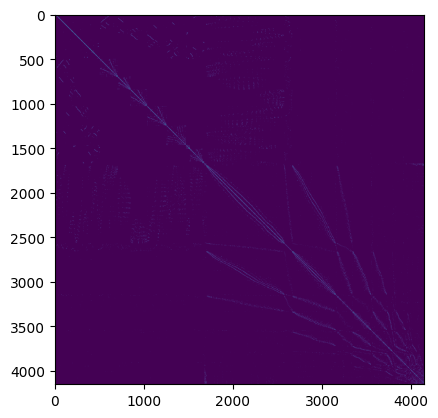

In [52]:
plt.imshow(AM)

In [53]:
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()

In [54]:
train_init_pos_main

tensor([[39.2660, 33.0940, 33.9440],
        [46.8680, 57.1290, 51.8520],
        [22.3480, 43.2940, 49.8210],
        ...,
        [54.9290, 45.5750, 33.1110],
        [25.8770, 45.5720, 26.5590],
        [35.8910, 26.4700, 50.9610]], grad_fn=<ToCopyBackward0>)

In [55]:
indice_nodos_train=[i-1 for i in data.index_train]

In [56]:
AM[indice_nodos_train][:,indice_nodos_train].shape

(3452, 3452)

In [57]:
AM[indice_nodos_train,indice_nodos_train]

array([1., 1., 1., ..., 1., 1., 1.])

In [58]:
indice_nodos_test=[i-1 for i in data.index_test]

# Convertir la matriz de adyacencia en un grafo NetworkX
G_test = nx.from_numpy_array(AM[indice_nodos_test][:,indice_nodos_test])

# Convertir el grafo NetworkX en un Data object de PyG
edge_index_test = from_networkx(G_test).edge_index

# Separar las características (XYZ) y las etiquetas (UVW)
node_features_test = train_init_pos_main
node_labels_test = train_disp_main

# Crear el objeto Data
data_graph_test = torch_geometric.data.Data(x=node_features_test, edge_index=edge_index_test,y=node_labels_test)


In [59]:


# Convertir la matriz de adyacencia en un grafo NetworkX
G = nx.from_numpy_array(AM[indice_nodos_train][:,indice_nodos_train])

# Convertir el grafo NetworkX en un Data object de PyG
edge_index = from_networkx(G).edge_index

# Separar las características (XYZ) y las etiquetas (UVW)
node_features = train_init_pos_main
node_labels = train_disp_main

# Crear el objeto Data
data_graph = torch_geometric.data.Data(x=node_features, edge_index=edge_index,y=node_labels)


In [60]:
class GraphNetwork(torch.nn.Module):
    def __init__(self, num_features):
        super(GraphNetwork, self).__init__()
        self.conv1 = GCNConv(num_features, 128)
        self.conv2 = GCNConv(128, 256)
        self.conv3 = GCNConv(256, 128)
        self.conv4 = GCNConv(128, 3)  # 3 para UVW

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.conv2(x, edge_index))
        x = F.relu(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)

        return x


In [61]:

train_loader = torch_geometric.loader.DataLoader([data_graph], batch_size=32, shuffle=True)
test_loader = torch_geometric.loader.DataLoader([data_graph_test], batch_size=32, shuffle=True)


In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_graph=data_graph.to(device)
data_graph_test=data_graph_test.to(device)
model = GraphNetwork(num_features=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
criterion = torch.nn.MSELoss()

model.train()
for epoch in range(3060):
    optimizer.zero_grad()
    output = model(data_graph)
    loss = criterion(output, data_graph.y)
    print(loss.item())

    loss.backward()
    optimizer.step()

5.152525424957275
856.17822265625
32.942501068115234
23.84909439086914
12.384819984436035
5.33894681930542
4.166461944580078
5.133971214294434
5.2872843742370605
5.028313636779785
3.9028656482696533
3.2692506313323975
3.8194332122802734
3.9067907333374023
3.45737886428833
3.453972578048706
3.2185633182525635
3.0691187381744385
3.2238526344299316
2.87831449508667
2.7446680068969727
2.690122127532959
2.356748580932617
2.307039260864258
2.1106035709381104
2.106877565383911
1.9337246417999268
1.9845088720321655
2.0110909938812256
2.0100224018096924
1.998778223991394
1.9050023555755615
1.9053583145141602
1.8234952688217163
1.7694377899169922
1.8429291248321533
1.807094693183899
1.8402135372161865
1.7676180601119995
1.7519571781158447
1.761086106300354
1.7218637466430664
1.703702449798584
1.6979024410247803
1.62995445728302
1.5653026103973389
1.637624740600586
1.655121922492981
1.5850310325622559
1.5949147939682007
1.6336439847946167
1.5954307317733765
1.5629984140396118
1.4852924346923828
1

KeyboardInterrupt: 

In [46]:
# Función de entrenamiento
def train():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Ciclo de entrenamiento
for epoch in range(1000):  # Número de épocas
    train_loss = train()
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}')

Epoch: 0, Train Loss: 6.4985
Epoch: 1, Train Loss: 6.0930
Epoch: 2, Train Loss: 5.9060
Epoch: 3, Train Loss: 6.0808
Epoch: 4, Train Loss: 5.8803
Epoch: 5, Train Loss: 6.2879
Epoch: 6, Train Loss: 6.3365
Epoch: 7, Train Loss: 5.9602
Epoch: 8, Train Loss: 5.8768
Epoch: 9, Train Loss: 5.6913
Epoch: 10, Train Loss: 5.7360
Epoch: 11, Train Loss: 5.8309
Epoch: 12, Train Loss: 5.7456
Epoch: 13, Train Loss: 5.8721
Epoch: 14, Train Loss: 5.6212
Epoch: 15, Train Loss: 5.4385
Epoch: 16, Train Loss: 5.3842
Epoch: 17, Train Loss: 5.5282
Epoch: 18, Train Loss: 5.5231
Epoch: 19, Train Loss: 5.5572
Epoch: 20, Train Loss: 5.4804
Epoch: 21, Train Loss: 5.2927
Epoch: 22, Train Loss: 5.1039
Epoch: 23, Train Loss: 5.3633
Epoch: 24, Train Loss: 5.0444
Epoch: 25, Train Loss: 5.0487
Epoch: 26, Train Loss: 5.1827
Epoch: 27, Train Loss: 5.0160
Epoch: 28, Train Loss: 5.0561
Epoch: 29, Train Loss: 4.9672
Epoch: 30, Train Loss: 5.0859
Epoch: 31, Train Loss: 5.0539
Epoch: 32, Train Loss: 5.2090
Epoch: 33, Train Los

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_graph=data_graph.to(device)
data_graph_test=data_graph_test.to(device)
model = GraphNetwork(num_features=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)#, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data_graph)
    loss = criterion(out, data_graph.y)
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    with torch.no_grad():
        out = model(data_graph_test)
        test_loss = criterion(out, data_graph_test.y).item()
    return test_loss

# Entrenamiento
for epoch in range(14):  # Número de épocas
    train_loss = train()
    test_loss = test()
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')


Epoch: 0, Train Loss: 7.7963, Test Loss: 1752.9901
Epoch: 1, Train Loss: 1800.9623, Test Loss: 87.8552
Epoch: 2, Train Loss: 92.2421, Test Loss: 1.2738
Epoch: 3, Train Loss: 1.3826, Test Loss: 1.9441
Epoch: 4, Train Loss: 2.0425, Test Loss: 3.4435
Epoch: 5, Train Loss: 3.6930, Test Loss: 3.4798
Epoch: 6, Train Loss: 3.6003, Test Loss: 2.1405
Epoch: 7, Train Loss: 2.2640, Test Loss: 0.8751
Epoch: 8, Train Loss: 0.9074, Test Loss: 0.2619
Epoch: 9, Train Loss: 0.2727, Test Loss: 0.8225
Epoch: 10, Train Loss: 0.7962, Test Loss: 0.9972
Epoch: 11, Train Loss: 0.9853, Test Loss: 0.6769
Epoch: 12, Train Loss: 0.6706, Test Loss: 0.3565
Epoch: 13, Train Loss: 0.3629, Test Loss: 0.2561


In [63]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_graph=data_graph.to(device)
data_graph_test=data_graph_test.to(device)
model = GraphNetwork(num_features=3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=5e-4)
criterion = torch.nn.MSELoss()
def train():
    model.train()
    total_loss = 0
    for data in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, data.y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def test():
    model.eval()
    total_test_loss = 0
    with torch.no_grad():
        for data in test_loader:
            data = data.to(device)
            out = model(data)
            test_loss = criterion(out, data.y).item()
            total_test_loss += test_loss
    return total_test_loss / len(test_loader)

# Entrenamiento
for epoch in range(2060):  # Número de épocas
    train_loss = train()
    test_loss = test()
    print(f'Epoch: {epoch}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}')

Epoch: 0, Train Loss: 16.6896, Test Loss: 6.4652
Epoch: 1, Train Loss: 7.0824, Test Loss: 9.5230
Epoch: 2, Train Loss: 10.1143, Test Loss: 7.4095
Epoch: 3, Train Loss: 8.3386, Test Loss: 4.7122
Epoch: 4, Train Loss: 5.4347, Test Loss: 3.9391
Epoch: 5, Train Loss: 4.0436, Test Loss: 4.6091
Epoch: 6, Train Loss: 4.4046, Test Loss: 5.4078
Epoch: 7, Train Loss: 4.8934, Test Loss: 5.3348
Epoch: 8, Train Loss: 4.7804, Test Loss: 4.4032
Epoch: 9, Train Loss: 3.9549, Test Loss: 3.3088
Epoch: 10, Train Loss: 3.2145, Test Loss: 2.7241
Epoch: 11, Train Loss: 2.5559, Test Loss: 2.7127
Epoch: 12, Train Loss: 3.0000, Test Loss: 2.8521
Epoch: 13, Train Loss: 3.2057, Test Loss: 2.8997
Epoch: 14, Train Loss: 3.3674, Test Loss: 2.8409
Epoch: 15, Train Loss: 2.9756, Test Loss: 2.7432
Epoch: 16, Train Loss: 2.7296, Test Loss: 2.6289
Epoch: 17, Train Loss: 2.5448, Test Loss: 2.5293
Epoch: 18, Train Loss: 2.3749, Test Loss: 2.4611
Epoch: 19, Train Loss: 2.4432, Test Loss: 2.4340
Epoch: 20, Train Loss: 2.239

In [70]:
aux_plot=pd.concat([pd.DataFrame(test_init_pos_main.detach().cpu().numpy(),columns=["X","Y","Z"]),pd.DataFrame(test_disp_main.detach().cpu().numpy(),columns=["U","V","W"])],axis=1)
aux_plot["USUM"]=np.sqrt(aux_plot["U"]**2+aux_plot["V"]**2+aux_plot["W"]**2)
aux_plot

,X,Y,Z,U,V,W,USUM
0,43.752998,58.023998,51.280998,-0.120380,-7.28060,2.431200,7.676742
1,25.990000,56.678001,45.543999,-0.199590,-10.21400,2.060600,10.421694
2,46.352001,44.209999,33.763000,0.462400,-4.31750,0.051863,4.342501
3,27.495001,39.759998,50.173000,-1.513000,-3.37140,2.333000,4.370171
4,45.313000,40.136002,38.727001,0.573980,-3.62100,1.216200,3.862672
...,...,...,...,...,...,...,...
694,32.023998,56.054001,46.952999,-0.013569,-9.29680,2.572900,9.646268
695,50.841000,32.540001,34.917000,0.388800,-0.57932,0.401080,0.804762
696,21.382999,50.812000,44.316002,-1.246900,-3.58340,1.797500,4.198395
697,29.891001,42.105999,25.903000,-0.353810,-2.73200,-0.826040,2.875995


In [71]:
aux_pred=pd.DataFrame(model(data_graph_test).detach().cpu().numpy()[:,:3],columns=["pred_U","pred_V","pred_W"])
aux_plot["pred_X"]=aux_plot["X"]+aux_pred["pred_U"]
aux_plot["pred_Y"]=aux_plot["Y"]+aux_pred["pred_V"]
aux_plot["pred_Z"]=aux_plot["Z"]+aux_pred["pred_W"]
aux_plot["real_X"]=aux_plot["X"]+aux_plot["U"]
aux_plot["real_Y"]=aux_plot["Y"]+aux_plot["V"]
aux_plot["real_Z"]=aux_plot["Z"]+aux_plot["W"]
aux_plot["dif_real_pred_X"]=aux_plot["real_X"]-aux_plot["pred_X"]
aux_plot["dif_real_pred_Y"]=aux_plot["real_Y"]-aux_plot["pred_Y"]
aux_plot["dif_real_pred_Z"]=aux_plot["real_Z"]-aux_plot["pred_Z"]
aux_plot["relativ_dif_real_pred_X"]=aux_plot["dif_real_pred_X"]/aux_plot["U"]
aux_plot["relativ_dif_real_pred_Y"]=aux_plot["dif_real_pred_Y"]/aux_plot["V"]
aux_plot["relativ_dif_real_pred_Z"]=aux_plot["dif_real_pred_Z"]/aux_plot["W"]

In [72]:
aux_plot

,X,Y,Z,U,V,W,USUM,pred_X,pred_Y,pred_Z,real_X,real_Y,real_Z,dif_real_pred_X,dif_real_pred_Y,dif_real_pred_Z,relativ_dif_real_pred_X,relativ_dif_real_pred_Y,relativ_dif_real_pred_Z
0,43.752998,58.023998,51.280998,-0.120380,-7.28060,2.431200,7.676742,44.027710,55.823448,52.334332,43.632618,50.743397,53.712196,-0.395092,-5.080051,1.377865,3.282040,0.697752,0.566743
1,25.990000,56.678001,45.543999,-0.199590,-10.21400,2.060600,10.421694,25.971375,53.785423,46.393429,25.790409,46.464001,47.604599,-0.180965,-7.321423,1.211170,0.906686,0.716803,0.587775
2,46.352001,44.209999,33.763000,0.462400,-4.31750,0.051863,4.342501,46.156551,39.837208,35.741283,46.814400,39.892498,33.814865,0.657848,0.055290,-1.926418,1.422683,-0.012806,-37.144367
3,27.495001,39.759998,50.173000,-1.513000,-3.37140,2.333000,4.370171,27.754309,36.615707,52.274452,25.982000,36.388599,52.506001,-1.772308,-0.227108,0.231548,1.171387,0.067363,0.099249
4,45.313000,40.136002,38.727001,0.573980,-3.62100,1.216200,3.862672,45.015713,37.154652,40.072807,45.886978,36.515003,39.943203,0.871265,-0.639648,-0.129604,1.517937,0.176650,-0.106565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
694,32.023998,56.054001,46.952999,-0.013569,-9.29680,2.572900,9.646268,31.198019,53.903492,48.260532,32.010429,46.757202,49.525898,0.812410,-7.146290,1.265366,-59.872528,0.768683,0.491805
695,50.841000,32.540001,34.917000,0.388800,-0.57932,0.401080,0.804762,51.042915,28.235554,36.386692,51.229801,31.960680,35.318081,0.186886,3.725126,-1.068611,0.480673,-6.430170,-2.664334
696,21.382999,50.812000,44.316002,-1.246900,-3.58340,1.797500,4.198395,21.928652,47.442734,45.642075,20.136099,47.228600,46.113503,-1.792553,-0.214134,0.471428,1.437608,0.059757,0.262269
697,29.891001,42.105999,25.903000,-0.353810,-2.73200,-0.826040,2.875995,30.305759,38.204872,27.743240,29.537191,39.374001,25.076960,-0.768568,1.169128,-2.666281,2.172262,-0.427939,3.227786


In [94]:
# Crear una figura con subplots
fig = make_subplots(rows=1, cols=3, 
                    specs=[[{'type': 'scatter3d'}, {'type': 'scatter3d'}, {'type': 'scatter3d'}]])

# Añadir el primer gráfico tridimensional
fig.add_trace(go.Scatter3d(
    x=aux_plot['real_X'],
    y=aux_plot['real_Y'],
    z=aux_plot['real_Z'],
    mode='markers',
    marker=dict(size=18, color=aux_plot['USUM']),
    #name='Real'
), row=1, col=1)

# Añadir el segundo gráfico tridimensional
fig.add_trace(go.Scatter3d(
    x=aux_plot['pred_X'],
    y=aux_plot['pred_Y'],
    z=aux_plot['pred_Z'],
    mode='markers',
    marker=dict(size=18, color=aux_plot['USUM']),
    #name='Predicción'
), row=1, col=2)

# Añadir el tercer gráfico tridimensional
fig.add_trace(go.Scatter3d(
    x=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.20, 'pred_X'],
    y=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.20, 'pred_Y'],
    z=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.20, 'pred_Z'],
    mode='markers',
    marker=dict(size=16, color=aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"] > 0.1, 'USUM']),
    #name='Puntos con Error > 10%'
), row=1, col=3)

# Actualizar el layout de la figura
fig.update_layout(height=600, width=1800, title_text="                                  REAL                                                                                                                                                   PREDICCIÓN                                                                               Puntos con Err. relativo >10%")

# Mostrar la figura
fig.show()


In [ ]:
px.scatter_3d(aux_plot,x="real_X",y="real_Y",z="real_Z",color="USUM")

In [ ]:
px.scatter_3d(aux_plot,x="pred_X",y="pred_Y",z="pred_Z",color="USUM")

In [ ]:
px.scatter_3d(aux_plot.loc[aux_plot["relativ_dif_real_pred_Y"]>0.1],x="pred_X",y="pred_Y",z="pred_Z",color="USUM")

---  
Obtener solo la superficie, test. No va a funcionar esto.

In [79]:
puntos=aux_plot[["X","Y","Z"]].to_numpy()

In [80]:
import numpy as np
from scipy.spatial import ConvexHull
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


In [81]:
hull = ConvexHull(puntos)
surface_points = puntos[hull.vertices]


In [93]:
px.scatter_3d(pd.DataFrame(surface_points,columns=["X","Y","Z"]),x="X",y="Y",z="Z",color=aux_plot["USUM"].iloc[hull.vertices])

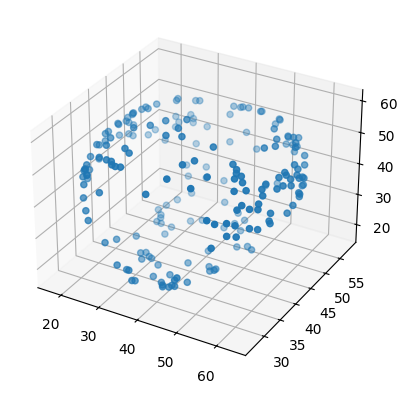

In [86]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(surface_points[:,0], surface_points[:,1], surface_points[:,2])
plt.show()


---

# Y ahora con tema PINN

NO se añadirlo. 

In [128]:
# Red neuronal  

class DNN(nn.Module):
    def __init__(self,layers,init_w="xavier"):
        super().__init__() 
        self.layers=layers
        self.activation = nn.Tanh()
        self.linears = nn.ModuleList([GCNConv(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        if init_w=="xavier":
            #Xavier Normal Initialization
            for i in range(len(layers)-1):
                nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
                
                # set biases to zero
                nn.init.zeros_(self.linears[i].bias.data)
        # elif init_w=="gorot":
        #         nn.init. (self.linears[i].weight.data, gain=1.0)
                
        #         # set biases to zero
        #         nn.init.zeros_(self.linears[i].bias.data)


    def forward(self,data):
        x, edge_index = data.x, data.edge_index

              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)             

        #xn = normalize(x, Pos_min, Pos_max)

        # convert to float
        a = x.float()
        

        # inpunt and hidden layers forward computation
        for i in range(len(self.layers)-2):
            z = self.linears[i](a,edge_index)          
            a = self.activation(z)

        # output layer forward computation            
        b = self.linears[-1](a)
        
        return b

In [129]:
class PINN(DNN):
    '''
        Esta clase hace el registro de todos los parámetros, los cálculos de derivadas y de losses
        Y aplica las restricciones que hagan falta
    '''
    def __init__(self, layers,init_values=None,device=None,separate_data_losses=True,loss_weights={"Data":1,"PDE":1,"BC":1}):
        super().__init__(layers)
        
        if device is None:
            self.device= "cuda" if torch.cuda.is_available() else "cpu"
        else:
            self.device=device
        self.to(self.device)


        #History of losses
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
         #Parameters trials
        self.params_history = { "E": [] ,
                                "alpha": []}

        #inicialización de parametros
        self.nu = init_values[0]
        self.alpha = nn.Parameter(torch.tensor(init_values[2],dtype=torch.float32).to(self.device))
        self.E_ref = init_values[1]
        self.E = torch.tensor((1+self.alpha)*self.E_ref,dtype=torch.float32).to(self.device)
        self.separate_data_losses=separate_data_losses
        self.loss_function = nn.MSELoss(reduction ='mean')

        self.w_data=loss_weights["Data"]
        self.w_PDE=loss_weights["PDE"]
        self.w_BC=loss_weights["BC"]
        self.iter_n=0

    def compute_XYZ(self, positions):
        # clone the input data and add AD
        pos = positions.clone().to(self.device)
        X = pos[:,0].reshape(-1,1)
        Y = pos[:,1].reshape(-1,1)
        Z = pos[:,2].reshape(-1,1)
        return X, Y, Z

    def compute_displacements(self,X, Y, Z):
        XYZ = torch.cat((X,Y,Z), dim=1).to( self.device )
        # Compute the output of the DNN
        U = self(XYZ)
        # Separating vector of directional displacements
        u = U[:,0].reshape(-1,1)
        v = U[:,1].reshape(-1,1)
        w = U[:,2].reshape(-1,1)
        return u, v, w

    # Los cálculos de las funciones de pérdida de hacen 1 vez, y luego ya vemos que hacemos
    # con esos datos, si usar pesos, si usar otras cosas...

    def loss_PDE(self, collocation_points, save = True):
        # estos son los puntos en los que imponemos las leyes físicas  
        # puede ser la ecuación de equilibrio, pero también pueden ser otras relaciones
        # que conozcamos entre inputs y outputs, como por ejemplo, relaciones termodinámicas etc..
        # si el output fuera posicion y tensión, entonces podriamos imponer la ley de hooke sobre este
        # input.
        X, Y, Z = self.compute_XYZ(collocation_points)
        u, v, w = self.compute_displacements(X,Y,Z)


        # y ahora tenemos que obtener las derivadas necesarias para aplicar la eq de equilibrio
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon)
        div_sigma = self.divergence(sigma,X, Y, Z)

        value_loss_PDE=self.loss_function(div_sigma,torch.zeros_like(div_sigma).to(self.device))
        
        if save:
            self.loss_history["PDE"].append(value_loss_PDE.item())#.to('cpu').detach().numpy())
        
        return value_loss_PDE
    
    def loss_BC(self,pos_reales,sigmas_reales,save=True):
        #aqui tenemos las de Dirichlet y las de Neumann
        # en mi caso que no hay contacto ni nada, pero si tengo nodos fijos!! las de Dirichlet tbn

        #en esta implementación voy a imponer las sigmas solo aqui, en una futura, podría meter también
        #las de Dirichlet para poder darles mas peso

        #calculamos sobre las posiciones de las sigmas que tenemos, las dadas por el modelo
        # predict U
        X,Y,Z=self.compute_XYZ(pos_reales)
        u, v, w=self.compute_displacements(X,Y,Z)
        
        epsilon = self.compute_strain(X,Y,Z,u, v, w)
        sigma = self.compute_stress(epsilon) 
        #este sigma tiene primera dimension batchsize, y segunda dimension 6
        #que corresponde con: s11,s22,s33,s23,s13,s12
        #le imponemos que sean iguales de modo que aplicamos la loss y ya
        value_loss_BC=self.loss_function(sigma,sigmas_reales)

        if save:
            self.loss_history["BC"].append(value_loss_BC.item())#.to('cpu').detach().numpy())

        return value_loss_BC

    #def loss_DBC(fix_nodes)
    #   pass

    def loss_data(self, pos_reales,desp_reales,save=True):
        #pos_reales=pos_reales.to(device)
        u_predict=self(pos_reales)
        if self.separate_data_losses:
            sepatared_loss=torch.nn.MSELoss(reduction="none")
            #aux=self.loss_function(u_predict,desp_reales)
            #esto nos devuelve la diferencia cuadrática de cada elemento, para evaluarlos por
            #separado, vamos a hacer la media en columnas
            # x_mse,y_mse,z_mse=torch.mean(aux,axis=0)
            # x_mse,y_mse,z_mse=torch.sqrt(x_mse),torch.sqrt(y_mse),torch.sqrt(z_mse)
            value_loss_data=torch.mean(torch.sqrt(torch.mean(sepatared_loss(u_predict,desp_reales),axis=0)))
        else:
            value_loss_data=self.loss_function(u_predict,desp_reales)

        if save:
            self.loss_history["Data"].append(value_loss_data.item())#.to('cpu').detach().numpy())
        
        return value_loss_data
    
    def loss(self, pos_data,desp_data,pos_colloc,pos_BC,sigmas_BC,save=True):
        #esto hace que se calculen todas las losses de la pinn
        #además, si tenemos un parámetro E, este se actualizará, pe si estamos actualizando alpha en lugar
        #de E, despues de la recalculación tendremos que actualizar E. 

        #actualizamos E antes de calcular nada

        self.E=(1+self.alpha)*self.E_ref

        value_loss_PCE=self.loss_PDE(pos_colloc,save=save)
        value_loss_BC=self.loss_BC(pos_BC,sigmas_BC,save=save)
        value_loss_data=self.loss_data(pos_data,desp_data,save=save)  
        value_loss= self.w_data*value_loss_data + self.w_PDE*value_loss_PCE+ self.w_BC*value_loss_BC


        if save: 
            #self.params_history["nu"].append(self.nu)#self.nu.to('cpu').detach().numpy())
            self.params_history["E"].append(self.E.to('cpu').detach().numpy())
            self.params_history["alpha"].append(self.alpha.to('cpu').detach().numpy())
            self.loss_history["Total"].append(value_loss.item())#.to('cpu').detach().numpy())

        return value_loss

    def compute_gradU(self, X, Y, Z, U, V, W):

        # Compute the gradient of U
        Ux,Uy,Uz = autograd.grad(U, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Uy = autograd.grad(U, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Uz = autograd.grad(U, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of V
        Vx,Vy,Vz = autograd.grad(V, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Vy = autograd.grad(V, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Vz = autograd.grad(V, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        # Compute the gradient of W
        Wx,Wy,Wz = autograd.grad(W, (X,Y,Z), torch.ones([X.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)
        # Wy = autograd.grad(W, Y, torch.ones([Y.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]
        # Wz = autograd.grad(W, Z, torch.ones([Z.shape[0], 1]).to(self.device),retain_graph=True, create_graph=True)[0]

        grad_u = torch.cat((Ux , Uy, Uz), dim=1).to(torch.float32)
        grad_v = torch.cat((Vx , Vy, Vz), dim=1).to(torch.float32)
        grad_w = torch.cat((Wx , Wy, Wz), dim=1).to(torch.float32)

        gradU = torch.cat((grad_u, grad_v, grad_w), dim=1).to(torch.float32).reshape(-1,3,3)

        return gradU

    def compute_strain(self, X,Y,Z,u, v, w):
        # Compute strain components using autograd
        nabla_U = self.compute_gradU(X,Y,Z,u, v, w).squeeze()
        strain = 0.5 * (nabla_U + nabla_U.swapaxes(1,2))
        return strain


    def compute_stress(self,strain):
        strain_flat=strain[:,(0,1,2,1,0,0),(0,1,2,2,2,1)]*torch.tensor([1,1,1,2,2,2],dtype=torch.float32).to(self.device)
        #strain_flat=strain[:,(0,1,2,0,0,1),(0,1,2,1,2,2)] # e00,e11,e22,e01,e02,e12
        self.C=(self.E/((1+self.nu)*(1-2*self.nu)))*torch.tensor(
                [[1-self.nu,self.nu,self.nu,0,0,0],
                [self.nu,1-self.nu,self.nu,0,0,0],
                [self.nu,self.nu,1-self.nu,0,0,0],
                [0,0,0,(1-2*self.nu)/2,0,0],
                [0,0,0,0,(1-2*self.nu)/2,0],
                [0,0,0,0,0,(1-2*self.nu)/2]]).float().to(self.device)

        return torch.matmul(self.C,strain_flat.T.float()).T.squeeze() #s11,s22,s33,s23,s13,s12

    def divergence(self,sigma, X, Y, Z):
        div_T = torch.zeros(sigma.shape[0],3)
        div_T[:,0]=autograd.grad(sigma[:,0],X,grad_outputs=torch.ones_like(sigma[:,0]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,5],Y,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,4],Z,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,1]=autograd.grad(sigma[:,5],X,grad_outputs=torch.ones_like(sigma[:,5]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,1],Y,grad_outputs=torch.ones_like(sigma[:,1]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Z,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()
        div_T[:,2]=autograd.grad(sigma[:,4],X,grad_outputs=torch.ones_like(sigma[:,4]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,3],Y,grad_outputs=torch.ones_like(sigma[:,3]).to(self.device),retain_graph=True)[0].squeeze()+autograd.grad(sigma[:,2],Z,grad_outputs=torch.ones_like(sigma[:,2]).to(self.device),retain_graph=True)[0].squeeze()

        return div_T
    

    def step_closure(self,opt,train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2):
        
        opt.zero_grad()
        
        loss = self.loss(train_init_pos_main2,train_disp_main2,return_colloc_points2,position_selected_stresses2,return_stress2)
        
        loss.backward()
        self.iter_n+=1
        # Print material parameters and loss evolition
        print(f'LBFGS iter: {self.iter_n}, Loss: {loss.item()}')
            
        
        return loss


In [132]:
#tenemos que cargar correctamente los datos para usarlos
data=Data("MULTIPLE_E_VALUES_NEW",10,E="0.005")
data.load_data()
train_init_pos_main,train_disp_main,test_init_pos_main,test_disp_main,position_selected_stresses,return_stress,return_colloc_points=data.prepare_pytorch_data()